In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks
from ucimlrepo import fetch_ucirepo 

from keras.models import Sequential
from keras.layers import Dense, Activation   
from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, LSTM, Embedding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report
from sklearn.datasets import load_iris, load_digits, fetch_20newsgroups_vectorized, fetch_olivetti_faces

2025-04-22 09:55:52.563260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Lecture 10 (Neural Networks)

## The Gradient Descent

Consider the following problem: we have a multivariable function $F(x_1,\ldots,x_n)$ that we want to optimize, i.e. find the point at which $F$ attains its minimum or maximum. There is an iterative algorithm called [steepest descent algorithm](https://ocw.mit.edu/courses/mathematics/18-409-topics-in-theoretical-computer-science-an-algorithmists-toolkit-fall-2009/lecture-notes/MIT18_409F09_scribe21.pdf) that we can use to find this point. The algorithm uses the [gradient](https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_gradient.html) of the function. Recall that the gradient $\nabla F$ at a point $x$ 

$$ \nabla F = \left(\frac{\partial F}{\partial x_1},\ldots,\frac{\partial F}{\partial x_n}\right) $$

gives us the direction at which $F$ has the largest (in absolute value) derivative. The algorithm uses this information and iteratively pushes an initial guess into better and better approximations of the optimum point. Let us start with an initial guess $x^{(0)} = (x_1^{(0)},\ldots,x_n^{(0)})$ for a minimum of $F$, and move in the opposite direction of the gradient with a small step (called **learning rate**). Then the update rule for the path we are going to follow is

$$ x^{(m+1)} = x^{(m)} - \eta \left(\nabla F\right)(x_1^{(m)},\ldots,x_n^{(m)}) $$

where $\eta$ is called *the learning rate*. 

Now, let try to find a solution to $ f(x) = c $ using gradient descent. We convert the root-finding problem $f(x) = c$ into an optimization problem by minimizing the squared error $(f(x) - c)^2$. This approach is particularly effective when $f$ is differentiable but not invertible. Then we need the following function is minimized at $f(x)=c$

$$ F(x) = \frac{1}{2} (f(x) - c)^2 \quad \Rightarrow \quad \nabla F(x) = (f(x)-c) \nabla f(x) $$

The gradient $\nabla F(x)$ points in the direction of steepest increase of the function $F$. Therefore, to minimize $F$, we move in the direction $-\nabla F(x)$. So this update rule is:

$$ x^{(k+1)} = x^{(k)} - \eta (f(x^{(k)}) - c) \nabla f(x^{(k)}) $$


In [2]:
def MSolve(f, c, x0, lr=0.01, h=1e-5, tol=1e-5, n=15000):
    x0 = np.array(x0, dtype=float)
    dim = len(x0)
    
    def numerical_grad(f, x):
        grad = np.zeros_like(x)
        for i in range(len(x)):
            dx = np.zeros_like(x)
            dx[i] = h
            grad[i] = (f(x + dx) - f(x - dx)) / (2 * h)
        return grad

    for i in range(n):
        fx = f(x0)
        grad_f = numerical_grad(f, x0)
        x1 = x0 - lr * (fx - c) * grad_f
        if np.linalg.norm(x1 - x0) < tol:
            break
        x0 = x1
    return [i, x1]

Let us solve a specific example. Let $f(x,y) = x^2 + 3y^2$, let $c=0$, let initial point $(x_0,y_0)=(2,2)$ and let us set the learning rate at 0.01

In [3]:
def f(x):
    return x[0]**2 + 3 * x[1]**2

MSolve(f, c=0.0, x0=[2.0, 2.0], lr=1e-2)

[3952, array([7.93556903e-02, 1.49809119e-05])]

We started at the point $(2, 2)$ with the learning rate at set 0.01.  The red dots show the successive steps taken by the algorithm as it descends toward the minimum at the origin $(0, 0)$. This function is **convex**. The descent follows an **elliptical path**, with rapid convergence in $y$ and slower motion in $x$. The gradient is $ \nabla f(x, y) = (2x, 6y) $. So, the updates are:

$$ x^{(n+1)} = x^{(n)} - 0.01 \cdot 2x^{(n)},\quad y^{(n+1)} = y^{(n)} - 0.01 \cdot 6y^{(n)} $$

<center><img width="500px" src="../images/steepest_descent.png"></center>


## The Perceptron

Perceptrons are the main building blocks of artificial neural networks. They are designed to solve binary classification problems. They take a collection of input values $x = (x_1,\ldots,x_n)$ apply a linear combination 

$$\alpha\cdot x + \beta = a_1 x_1 + \cdots + a_n x_n + \beta$$ 

using a collection of weights $\alpha = (a_0,\ldots,a_n)$ and $\beta$ to be determined via an iterative approach. Then we apply an activation function $\varphi(x)$ to get an output which is either 0 or 1.

<center><img src="../images/perceptron.gif"></center>

[Source: Multilayer perceptrons from "Nonlinear Switching State-Space Models" by Antti Honkela](https://users.ics.aalto.fi/ahonkela/dippa/node41.html)

### The Optimization Problem

As in the case of logistic regression, we have a collection of data points $(x^{(i)},y^{(i)})$ that we assume satisfy a relationship of the form

$$ y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta) \sim N(0,\sigma) $$

where $\varphi\colon\mathbb{R}\to\mathbb{R}$ is a real valued function of a single variable, $\alpha$ and $x^{(i)}$ are vectors in an inner product space and $\beta$ is a scalar.  Our task is to find the best fitting pair $(\alpha,\beta)$ such that 

$$ \sum_i (y^{(i)} - \varphi(\alpha\cdot x^{(i)} + \beta))^2 $$

is minimized. This setup is a slight generalization of the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) algorithm we covered in earlier lectures.  In the logistic regression case $\varphi(x) = \frac{1}{1+e^{-x}}$.  Now, we can change $\varphi$. Here are a couple of options:

- Linear: $\varphi(z) = z$ (gives **linear regression**),
- Sigmoid: $\varphi(z) = \frac{1}{1 + e^{-z}}$ (logistic regression if combined with cross-entropy loss),
- ReLU: $\varphi(z) = \max(0,z)$,
- Tanh: $\varphi(z) = \tanh(z)$, etc.

### Minimizing MSE is Equivalent to MLE

Under the Gaussian noise assumption minimizing the MSE is equivalent to finding the maximum likelihood estimation. This is because when we write the likelihood function

$$
p(y^{(i)} \mid x^{(i)}; \alpha, \beta) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{1}{2\sigma^2} (y^{(i)} - \varphi(\alpha \cdot x^{(i)} + \beta))^2 \right)
$$

We obtain the log-likelihood over all samples as

$$
\log \mathcal{L}(\alpha, \beta) = -\frac{N}{2} \log(2\pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^N (y^{(i)} - \varphi(\alpha \cdot x^{(i)} + \beta))^2
$$

Maximizing this is equivalent to minimizing the following function

$$
\sum_{i=1}^N (y^{(i)} - \varphi(\alpha \cdot x^{(i)} + \beta))^2
$$

which justifies the choice of the squared loss.


### The Gradient Descent Update Rule

We are going to use a gradient descent method update to minimize $L(\alpha, \beta)$. Here we have a couple of options: We can use

1. the whole dataset (ordinary gradient descent)
2. a small random batch of points (batch gradient descent)
3. only a single point (stochastic gradient descent)

to calculate the mean square error. Below, I'll do SGD for simplicity, but you may use any of these methods. 

Suppose at iteration $n$, we randomly pick the data point $(x^{(n)}, y^{(n)})$, and define:

$$
\delta^{(n)} := \varphi(\alpha^{(n)} \cdot x^{(n)} + \beta^{(n)}) - y^{(n)}
$$

We define the **per-sample loss function** $\ell^{(n)}$ at the sample $(x^{(n)}, y^{(n)})$ as:

$$
\ell^{(n)}(\alpha,\beta) := (y^{(n)} - \varphi(\alpha^{(n)} \cdot x^{(n)} + \beta^{(n)}))^2 = (\delta^{(n)})^2
$$

We compute the gradient of $\ell^{(n)}$ with respect to $\alpha$ as follows: Let

$$
z^{(n)} := \alpha^{(n)} \cdot x^{(n)} + \beta^{(n)} \in \mathbb{R}
$$

Then

$$
\ell^{(n)} = (y^{(n)} - \varphi(z^{(n)}))^2
$$

Applying the chain rule:

$$
\nabla_\alpha \ell^{(n)} = 2(y^{(n)} - \varphi(z^{(n)})) \cdot (-\varphi'(z^{(n)})) \cdot x^{(n)} = -2 \delta^{(n)} \varphi'(z^{(n)}) x^{(n)}
$$

If we drop the constant $2$ into the learning rate $\eta$, the update for $\alpha$ and $\beta$, we obtain:

$$
\alpha^{(n+1)} = \alpha^{(n)} - \eta \cdot \delta^{(n)} \varphi'(z^{(n)}) x^{(n)}
\qquad
\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \delta^{(n)} \varphi'(z^{(n)})
$$

### Feed-forward and back-propagation

In the feed-forward stage of the computation, we calculate the output $\varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$. In the back-propagation phase, we calculate the error $y - \varphi(\alpha^{(n)}\cdot x + \beta^{(n)})$ and adjust the weights as described above to obtain the next iteration of weights $(\alpha^{(n+1)},\beta^{(n+1)})$.

### An example

For this example, we are going to use a [toy dataset](http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)) from UCI: 

In [4]:
sonar = fetch_ucirepo(id=151) 
  
sonar_X = sonar.data.features 
sonar_y_raw = sonar.data.targets 

In [5]:
encoder = LabelBinarizer()
sonar_y = encoder.fit_transform(sonar_y_raw)

In [6]:
def fit_predict(xs, ys, f, f_prime, epochs, track=10, eta=0.1, tol=1e-4):
    # Convert to NumPy arrays and add bias term
    X = np.hstack([np.ones((len(xs), 1)), xs])
    N, d = X.shape
    w = np.random.randn(d)
    errors = []

    for i in range(epochs):
        # Pick a random training sample
        j = np.random.randint(N)

        # Forward pass
        z = np.dot(w, X[j])
        a = f(z)
        delta = a - ys[j]

        # Update rule if error exceeds tolerance
        if abs(delta) > tol:
            grad = delta * f_prime(z) * X[j]
            w -= eta * grad

        # Track training error every 10 steps
        if i % track == 0:
            z_all = X @ w
            y_hat = f(z_all)
            mse = np.mean((y_hat - ys) ** 2)
            errors.append(mse)

    # Final prediction
    y_pred = f(X @ w)
    return y_pred, errors, w


Text(0, 0.5, 'MSE')

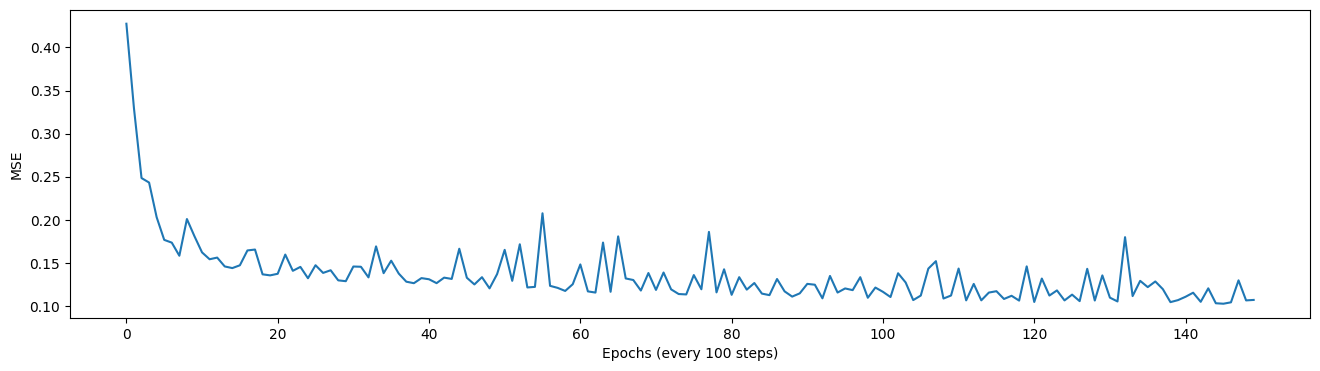

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Train
y_pred, errs, weights = fit_predict(sonar_X, sonar_y.reshape(-1), sigmoid, sigmoid_prime, epochs=15000, track=100, eta=0.5, tol=5e-4)

# Plot error
plt.figure(figsize=(16,4))
plt.plot(errs)
plt.xlabel("Epochs (every 100 steps)")
plt.ylabel("MSE")

In [10]:
def helper(x,th=0.5):
    if x>=th:
        return 1
    else:
        return 0
    
tmp = np.vectorize(helper)(y_pred).reshape(-1)

print(classification_report(sonar_y, tmp))
print("Accuracy:", accuracy_score(sonar_y, tmp))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       111
           1       0.80      0.89      0.84        97

    accuracy                           0.85       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.85      0.85      0.85       208

Accuracy: 0.8461538461538461


## Neural Networks

While perceptrons are limited in their ability to represent complex non-linear relationships, they can be composed into deeper architectures known as [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). 

Another way to describe a neural network is as a **directed computational graph** of perceptrons layered in stages:

<center>
<img width="450px" src="../images/neural-net.png">
</center>

Each layer applies a **linear transformation followed by a non-linear activation function**. If we denote by $x^i \in \mathbb{R}^{d_i}$ the vector of activations at layer $i$, and by $W^i \in \mathbb{R}^{d_{i+1} \times d_i}$ the weight matrix between layers $i$ and $i+1$, then the feedforward rule is:

$$
x^{i+1} = f^i(W^i x^i + b^i)
$$

where:
- $f^i$ is an activation function (e.g., ReLU, sigmoid),
- $b^i \in \mathbb{R}^{d_{i+1}}$ is a bias vector.

This transformation is applied layer by layer, from the input $x^0$ to the final output $x^L$, where $L$ is the number of layers.

Just as in the perceptron case, once an output is obtained, the error with respect to the true label is measured via a loss function (e.g., squared error or cross-entropy). Then, using a technique known as **backpropagation**, we compute gradients of the loss with respect to each weight via the **chain rule** of calculus.

These gradients are used to iteratively update weights via **gradient descent**:

$$
W^i \leftarrow W^i - \eta \cdot \frac{\partial \mathcal{L}}{\partial W^i}
$$

This completes one iteration of the **training phase** of the network.

Neural networks with just one hidden layer and sufficient width can approximate any continuous function on compact subsets of $\mathbb{R}^n$, a result known as the **universal approximation theorem**. There are [many different types of neural network architectures](http://www.asimovinstitute.org/neural-network-zoo/): convolutional networks for images, recurrent networks for sequences, transformers for language, and more.

Unlike simple perceptrons, implementing deep networks from scratch is **not recommended in practice**. 

<center>
<img src="../images/meme.jpg">
</center>

Instead, we use powerful open-source libraries such as:

1. [TensorFlow](https://www.tensorflow.org/)
2. [PyTorch](https://pytorch.org/)
3. [Keras](https://keras.io/) – high-level API on top of TensorFlow
4. [MXNet](https://mxnet.apache.org/)

For intuitive experimentation with small networks, I highly recommend the interactive [TensorFlow Playground](https://playground.tensorflow.org/), where you can design your own architectures and see how they learn in real time.


## An example 

All of todays examples are going to use the keras library. Let us start with the first example we used today, the sonar dataset. Let us construct a simple neural-net for binary classification, i.e. a perceptron:

In [11]:
model = Sequential()

model.add(Input(shape=(60,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

X_train, X_test, y_train, y_test = train_test_split(sonar_X,sonar_y,train_size=0.7)

2025-04-22 11:44:59.740546: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
model.fit(X_train, y_train, epochs=500, batch_size=20)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.5741 - loss: 0.6896  
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.5197 - loss: 0.6991 
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5141 - loss: 0.6992 
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5225 - loss: 0.7047 
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5631 - loss: 0.6759 
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5628 - loss: 0.6827 
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5047 - loss: 0.6993 
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5693 - loss: 0.6812 
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5813 - loss: 0.6670 
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5723 - loss: 0.6714 
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5064 - loss: 0.69

In [22]:
y_predict = model.predict(X_test)
tmp = np.vectorize(lambda x: helper(x,th=0.75))(y_predict.reshape(-1))
print(classification_report(y_test,tmp))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        31
           1       1.00      0.34      0.51        32

    accuracy                           0.67        63
   macro avg       0.80      0.67      0.63        63
weighted avg       0.80      0.67      0.63        63



## Another standard small example



In [23]:
iris = load_iris()
x_iris = iris['data']
y_iris = iris['target']

labeler = LabelBinarizer()
y = labeler.fit_transform(y_iris)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [28]:
model = Sequential()

model.add(Input(shape=(4,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

x_train, x_test, y_train, y_test = train_test_split(x_iris, y)

In [29]:
model.fit(x_train,y_train, epochs=250, batch_size=20)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.6164 - loss: 0.6528
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6667 - loss: 0.5885 
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6667 - loss: 0.5568 
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6779 - loss: 0.5193 
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7577 - loss: 0.4923 
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8667 - loss: 0.4693 
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8983 - loss: 0.4337 
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8777 - loss: 0.4159 
Epoch 9/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8895 - loss: 0.3974
Epoch 10/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - binary_accuracy: 0.8975 - loss: 0.3601
Epoch 11/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8858 - loss: 0.3556

In [31]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(accuracy_score(yy_test,yy_pred))
print(classification_report(yy_test,yy_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.85      0.92        13
           2       0.87      1.00      0.93        13

    accuracy                           0.95        38
   macro avg       0.96      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [32]:
np.round(100*y_pred,1)

array([[  0. ,  52.5,  53.3],
       [  0. ,   0.4,  99.8],
       [  0. ,   0.1, 100. ],
       [  0. ,  24.7,  77.3],
       [100. ,   0. ,   0. ],
       [  0. ,  99.9,   0. ],
       [  0. ,   0.1, 100. ],
       [100. ,   0. ,   0. ],
       [  0. ,   0. , 100. ],
       [  0. ,  96.4,   2.6],
       [  0. ,   0.3,  99.8],
       [  0. ,  99.9,   0. ],
       [  0.2,  99.6,   0.1],
       [100. ,   0.1,   0. ],
       [  0. ,  43.8,  59.7],
       [  0. ,  99.9,   0. ],
       [  0. ,   0. , 100. ],
       [  0.1,  99.9,   0. ],
       [  0. ,  99.8,   0.1],
       [100. ,   0.1,   0. ],
       [  1.4,  97.8,   0. ],
       [  0. ,   0. , 100. ],
       [ 99.8,   0.8,   0. ],
       [100. ,   0. ,   0. ],
       [  0. ,  21.1,  79.9],
       [100. ,   0.2,   0. ],
       [  0. ,  99.1,   0.5],
       [  0. ,  38.6,  64.1],
       [  0. ,   2.6,  98.2],
       [  0. ,  99.9,   0. ],
       [100. ,   0.1,   0. ],
       [100. ,   0.1,   0. ],
       [  0. ,  99.6,   0.2],
       [  

## A Large Example



In [33]:
digits = load_digits()
x_digits = digits['data']
y_digits = digits['target']

labeler = LabelBinarizer()

yy_digits = labeler.fit_transform(y_digits)
xx_digits = x_digits.reshape(1797,8,8,1)

x_train, x_test, y_train, y_test = train_test_split(xx_digits, yy_digits)

model = Sequential()

model.add(Input(shape=(8,8,1)))
model.add(Conv2D(32, (3, 2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [34]:
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8844 - loss: 0.4868
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9583 - loss: 0.1474 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9787 - loss: 0.0881 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9872 - loss: 0.0635 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9900 - loss: 0.0495 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9922 - loss: 0.0436 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9947 - loss: 0.0343 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9957 - loss: 0.0303 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9975 - loss: 0.0245 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9947 - loss: 0.0285 


In [35]:
y_pred = model.predict(x_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [36]:
print(classification_report(yy_test,yy_pred))
confusion_matrix(yy_test,yy_pred)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.98      1.00      0.99        42
           2       1.00      1.00      1.00        47
           3       0.93      0.98      0.96        58
           4       1.00      0.93      0.96        42
           5       0.89      1.00      0.94        42
           6       0.96      1.00      0.98        43
           7       0.97      0.97      0.97        37
           8       0.97      0.85      0.91        41
           9       0.98      0.92      0.95        49

    accuracy                           0.96       450
   macro avg       0.97      0.96      0.96       450
weighted avg       0.97      0.96      0.96       450



array([[48,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 57,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 39,  0,  1,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 42,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 43,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 36,  1,  0],
       [ 0,  1,  0,  3,  0,  1,  1,  0, 35,  0],
       [ 1,  0,  0,  1,  0,  2,  0,  0,  0, 45]])

## Yet Another Example


In [37]:
faces = fetch_olivetti_faces(data_home='/home/kaygun/local/data/scikit_learn_data/')
binarizer = LabelBinarizer()

y = binarizer.fit_transform(faces.target.flatten()).reshape(-1,40)
X = faces.data.flatten().reshape(-1,4096)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75)

In [38]:
model = Sequential()

model.add(Input(shape=(4096,)))
model.add(Dense(128, activation="relu",))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(40, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_test,y_test))

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 4.0289 - val_loss: 3.8790
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.7811 - val_loss: 3.7523
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.7033 - val_loss: 3.7278
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.6722 - val_loss: 3.6784
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.5953 - val_loss: 3.6561
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.5817 - val_loss: 3.6119
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.5182 - val_loss: 3.5883
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.4487 - val_loss: 3.5165
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.3786 - val_loss: 3.4967
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.2945 - val_loss: 3.3687
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.1866 - val_loss: 3.4359
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.1126 - val_lo

In [39]:
y_pred = model.predict(X_test)
yy_pred = np.argmax(y_pred,axis=1)
yy_test = np.argmax(y_test,axis=1)

print(classification_report(yy_test,yy_pred))
print(confusion_matrix(yy_test,yy_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         3
           6       0.67      1.00      0.80         2
           7       0.00      0.00      0.00         5
           9       0.17      1.00      0.29         1
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         1
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         1
          14       0.50      1.00      0.67         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         4
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00

/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
